<a href="https://colab.research.google.com/github/FarnazG/dsc-capstone-project-v2-online-ds-ft-120919/blob/master/Regression_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Modeling:**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import losses

import numpy as np #for numerical computations
import pandas as pd #for dataframe operations

from matplotlib import pyplot as plt #for viewing images and plots
%matplotlib inline 
#So that Matplotlib plots don't open in separate windows outside the notebook

import urllib #For fetching data from Web URLs

import cv2   #For image processing

from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of dataset

#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# **After 'X' is downloaded:**


In [0]:
# some URL images that were not readable were deleted:
X3 = np.load('/content/drive/My Drive/Capstone Project/X_gray_df2598.npy') 
X2 = np.load('/content/drive/My Drive/Capstone Project/X_gray_df2000.npy') 
X1 = np.load('/content/drive/My Drive/Capstone Project/X_gray_df1000.npy') 
X = np.concatenate((X1, X2, X3))
print(X.shape)

#gray image size grayscale 1 color
img_size=(400,300)

#colored image size RGB 3 Colors
#img_size=(400,300,3)

(2598, 120000)


To see how well the image processing works , we will fetch 5 samples from 'X' at random and plot them:

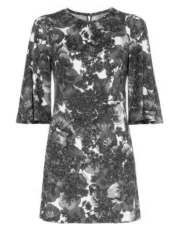

In [0]:
#Select 5 processed images at random from 'X' and plot 
for i in range(0, 1):
  plt.figure()
  plt.imshow(X[i].reshape(img_size), cmap='gray'), plt.axis('off')

**Splitting the data:**

We need to split the data into training, validation, and test sets.

**Creating the Target Array:**

We already have our 'X'. Now, we need our 'Y'.

We will ceate it from the 'Price' column of our dataframe.

if we use brand name column as 'y', It consists of the categorical labels. then We will map each label with a number using the LabelEncoder.

In [0]:
df= pd.read_csv('/content/drive/My Drive/Capstone Project/df.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,brand.id,brand.name,gender,hasSimilarProducts,id,images.cutOut,images.model,isCustomizable,merchandiseLabelField,merchantId,priceInfo.currencyCode,priceInfo.finalPrice,priceInfo.formattedFinalPrice,priceInfo.formattedInitialPrice,priceInfo.initialPrice,priceInfo.isOnSale,shortDescription,stockTotal
0,0,41,3440,Dolce & Gabbana,women,True,13951532,https://cdn-images.farfetch-contents.com/13/95...,https://cdn-images.farfetch-contents.com/13/95...,False,NewSeason,9359,SGD,1124,"$1,124","$1,124",1124,False,Geranium print mini dress,38
1,1,57,25354,Gucci,women,True,13579955,https://cdn-images.farfetch-contents.com/13/57...,https://cdn-images.farfetch-contents.com/13/57...,False,NoTag,9359,SGD,2200,"$2,200","$2,200",2200,False,Stirrups print blouse,13
2,2,122,547344,Saint Laurent,women,True,14031265,https://cdn-images.farfetch-contents.com/14/03...,https://cdn-images.farfetch-contents.com/14/03...,False,NewSeason,9359,SGD,2620,"$2,620","$2,620",2620,False,Zebra print peplum skirt,4
3,3,128,3440,Dolce & Gabbana,women,True,13951202,https://cdn-images.farfetch-contents.com/13/95...,https://cdn-images.farfetch-contents.com/13/95...,False,NewSeason,9359,SGD,3200,"$3,200","$3,200",3200,False,Lily print flounce dress,18
4,4,96,3440,Dolce & Gabbana,women,True,13922305,https://cdn-images.farfetch-contents.com/13/92...,https://cdn-images.farfetch-contents.com/13/92...,False,NoTag,9541,SGD,4273,"$4,273","$4,273",4273,False,graffiti art print jacket,1


In [0]:
#Y = df['priceInfo.initialPrice'].loc[0:29999]
Y = df['priceInfo.initialPrice']
Y.shape

(2598,)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


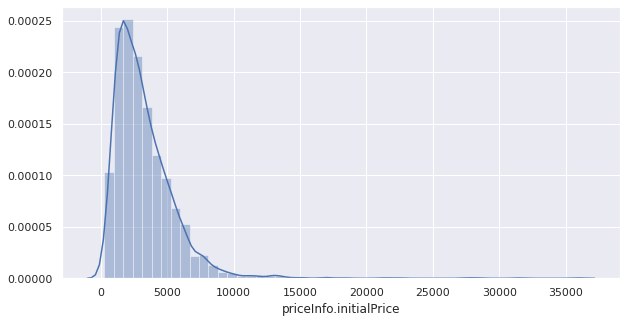

In [0]:
#Y.hist(figsize=(5,5))
#plt.show()

import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(Y)

Applying log transfer to normally distribute the price column.
at the end we wil revers the process to predict the real price. 

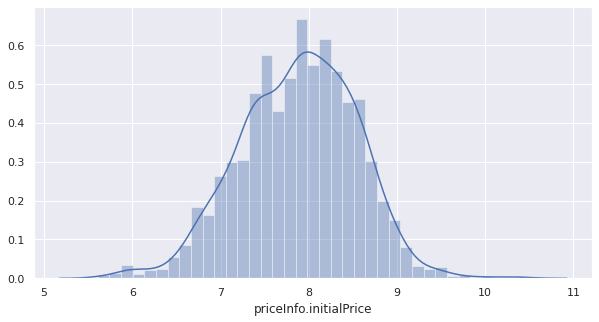

In [0]:
Y_log = np.log(Y)
sns.distplot(Y_log)

**Separation of a validation set, and a test set:**

In [0]:
#normalizing images between 0 and 1 before splitting the data
#X = X/255

# we consider 80% of our data as training and 20% as testing:
X_test = X[2500:,]
Y_test = Y_log[2500:,]

#Seperation of a validation set 15% from the remaing training set (required for validation while training)

X_train, X_val, Y_train, Y_val = train_test_split(X[:2500,], Y_log[:2500,], test_size=0.15, random_state=13)


**Reshaping the input data**

I know we reshaped out images earlier into 10000x1 row arrays, since it was easier to store them that way. But CNN requires input data in form of nice multi-dimensional grids. For our colored image data, the third dimesion will be 3.

In [0]:
#Reshape the input matrices such that each sample is three-dimensional

img_rows, img_cols = 400, 300
input_shape = (img_rows, img_cols, 1)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_train = X_train/255
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_test = X_test/255
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_val = X_val/255

X_val.shape

(375, 400, 300, 1)

# **Convolutional Neural Network**

Compiling the model

In [0]:
##Define a Convolutional Neural Network Model

##Sequential is the easiest way to build a model in Keras. It allows you to build a model layer by layer.
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
               input_shape = input_shape))
##Batch normalization automatically standardize the inputs to a layer
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
##The output layer
model.add(Dense(1, activation='linear'))

learning_rate = 0.01

model.compile(loss = 'mean_squared_error',
             optimizer = Adam(learning_rate),
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 398, 298, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 398, 298, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 396, 296, 16)      2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 396, 296, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 198, 148, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 198, 148, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 146, 32)      4

In [0]:
#def huber_loss_wrapper(**huber_loss_kwargs):
#  def huber_loss_wrapped_function(y_true, y_pred):
#    return keras.losses.huber_loss(y_true, y_pred, **huber_loss_kwargs)
#  return huber_loss_wrapped_function

In [0]:
#Define a Convolutional Neural Network Model

# #Sequential is the easiest way to build a model in Keras. It allows you to build a model layer by layer.
# model = Sequential()

# model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
#                  input_shape = input_shape))
# #Batch normalization automatically standardize the inputs to a layer
# #model.add(BatchNormalization())
# model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
# #model.add(BatchNormalization())
# model.add(MaxPool2D(strides=(1,1)))
# #model.add(Dropout(0.25))

# #model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
# #model.add(BatchNormalization())
# model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
# #model.add(BatchNormalization())
# model.add(MaxPool2D(strides=(1,1)))
# #model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.25))

# #model.add(Dense(1024, activation='relu'))
# #model.add(Dropout(0.4))
# #The output layer
# model.add(Dense(1, activation='linear'))

# learning_rate = 0.01

# #model.compile(loss = huber_loss_wrapper(delta=1.0),
# #              optimizer = Adam(learning_rate),
# #              metrics=['accuracy'])
# model.compile(loss = 'mean_squared_error',
#               optimizer = Adam(learning_rate),
#               metrics=['accuracy'])

# model.summary()

In [0]:
#Save the model during training 

save_at = "/content/drive/My Drive/Capstone Project/model.hdf5"
save_best = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

In [0]:
#Train the CNN

#history = model.fit( X_train, Y_train, 
#                   epochs = 5, batch_size = 1000, 
#                    callbacks=[save_best], verbose=1, 
#                    validation_data = (X_val, Y_val))

# Plot the training history (Training accuracy & Validation accuracy)

 #plt.figure(figsize=(6, 5))
 #plt.plot(history.history['accuracy'], color='r')
 #plt.plot(history.history['val_accuracy'], color='b')
 #plt.title('Model Accuracy', weight='bold', fontsize=16)
 #plt.ylabel('accuracy', weight='bold', fontsize=14)
 #plt.xlabel('epoch', weight='bold', fontsize=14)
 #plt.ylim(0.1, 0.9)
 #plt.xticks(weight='bold', fontsize=12)
 #plt.yticks(weight='bold', fontsize=12)
 #plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
 #plt.grid(color = 'y', linewidth='0.5')
 #plt.show()

Epoch 1/10
22/22 [==============================] - 316s 14s/step - loss: 40.5959 - accuracy: 0.0000e+00 - val_loss: 35.6546 - val_accuracy: 0.0000e+00
Epoch 2/10
22/22 [==============================] - 316s 14s/step - loss: 32.9678 - accuracy: 0.0000e+00 - val_loss: 32.1819 - val_accuracy: 0.0000e+00
Epoch 3/10
22/22 [==============================] - 317s 14s/step - loss: 52.3210 - accuracy: 0.0000e+00 - val_loss: 38.8745 - val_accuracy: 0.0000e+00
Epoch 4/10
22/22 [==============================] - 316s 14s/step - loss: 46.6385 - accuracy: 0.0000e+00 - val_loss: 48.4652 - val_accuracy: 0.0000e+00
Epoch 5/10
22/22 [==============================] - 318s 14s/step - loss: 37.3991 - accuracy: 0.0000e+00 - val_loss: 45.6346 - val_accuracy: 0.0000e+00
Epoch 6/10
22/22 [==============================] - 322s 15s/step - loss: 34.1585 - accuracy: 0.0000e+00 - val_loss: 43.6650 - val_accuracy: 0.0000e+00
Epoch 7/10
22/22 [==============================] - 318s 14s/step - loss: 37.5732 - accu

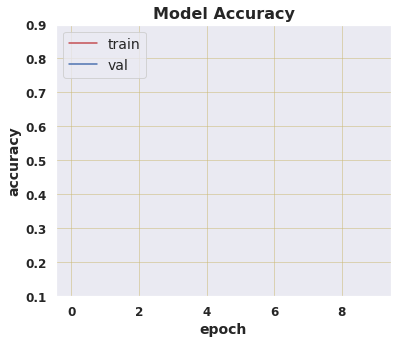

In [0]:
#Train the CNN

history = model.fit( X_train, Y_train, 
                    epochs = 10, batch_size = 100, 
                    callbacks=[save_best], verbose=1, 
                    validation_data = (X_val, Y_val))

# Plot the training history (Training accuracy & Validation accuracy)

plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy', weight='bold', fontsize=16)
plt.ylabel('accuracy', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.1, 0.9)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

The accuracy of the model is 0 which is not acceptable, so we stop and will continue with other approaches to solve the problem in next notebooks.